# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
!pip install gTTS
!pip install pydub

In [2]:
#Import all the required libraries

import os, glob
from glob import glob
import pickle
from sys import getsizeof

# Date and Time 
import datetime,time

# Data manipulation
import numpy as np
import pandas as pd
import collections, random, re
from collections import Counter


# Model building 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


#Read/Display  images
from skimage import io
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model

from gtts import gTTS



Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [3]:
#Import the dataset and read the image into a seperate variable

#images='../input/flickr8k/Images'
#text_file='../input/flickr8k/captions.txt'

images='./Flickr8K/Images'
text_file='./Flickr8K/captions.txt'

all_imgs = glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


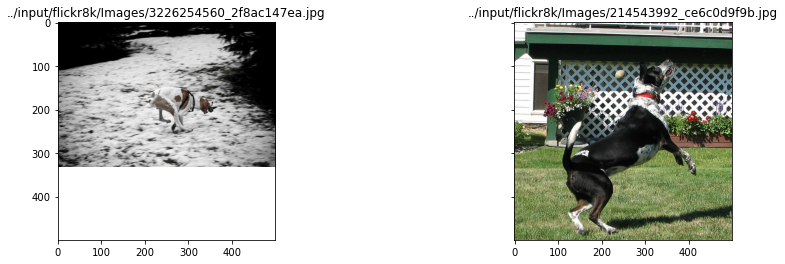

In [4]:
#Visualise both the images & text present in the dataset

def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
   
    for ax,image in zip(axes, images):
        ax.imshow(io.imread(image), cmap)
        ax.set_title(image)

plot_image(all_imgs[0:2])

In [5]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    text=pd.read_csv(filename)
    return text

doc = load_doc(text_file)
pd.set_option('display.max_colwidth',-1)
#print(doc[:300])
doc.head(300)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
...,...,...
295,1077546505_a4f6c4daa9.jpg,A boy in blue shorts slides down a slide into a pool .
296,1077546505_a4f6c4daa9.jpg,A boy in blue swimming trunks slides down a yellow slide into a wading pool with inflatable toys floating in the water .
297,1077546505_a4f6c4daa9.jpg,A boy rides down a slide into a small backyard pool .
298,1077546505_a4f6c4daa9.jpg,A boy sliding down a slide into a pool with colorful tubes .


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [6]:
all_img_id= doc['image'].str.split('_').str[0]#store all the image id here
all_img_vector= images+'/'+doc['image']#store all the image path here
annotations= doc['caption']#store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201,../input/flickr8k/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201,../input/flickr8k/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201,../input/flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201,../input/flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201,../input/flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
...,...,...,...
40450,997722733,../input/flickr8k/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733,../input/flickr8k/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733,../input/flickr8k/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles .
40453,997722733,../input/flickr8k/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [7]:
#Create the vocabulary & the counter for the captions
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(captions):
      
    words = []

    for sentence in captions:
        sent_words = split_sentence(sentence)
        for word in sent_words: 
            words.append(word)
    return sorted(words)

vocabulary= generate_vocabulary(df.Captions)

val_count=Counter(vocabulary)
val_count

Counter({'08': 1,
         '1': 2,
         '10': 1,
         '104': 2,
         '11': 2,
         '12': 4,
         '13': 4,
         '13406': 1,
         '157': 1,
         '17': 1,
         '19': 3,
         '1915': 1,
         '1923': 1,
         '1950s': 1,
         '2': 24,
         '2008': 1,
         '21': 2,
         '22': 1,
         '23': 5,
         '25': 3,
         '28': 3,
         '281': 2,
         '29': 1,
         '3': 18,
         '30': 1,
         '32': 1,
         '33': 1,
         '3rd': 2,
         '4': 20,
         '42': 1,
         '4x4': 1,
         '5': 19,
         '50': 1,
         '52': 2,
         '528': 1,
         '57': 1,
         '58': 2,
         '6': 9,
         '625': 1,
         '661': 1,
         '7': 3,
         '75': 1,
         '8': 17,
         '80': 1,
         '84': 2,
         '90': 1,
         '93': 1,
         '97': 1,
         'a': 62992,
         'abandon': 2,
         'abandoned': 5,
         'abarrotes': 1,
         'abdomen': 1,
  

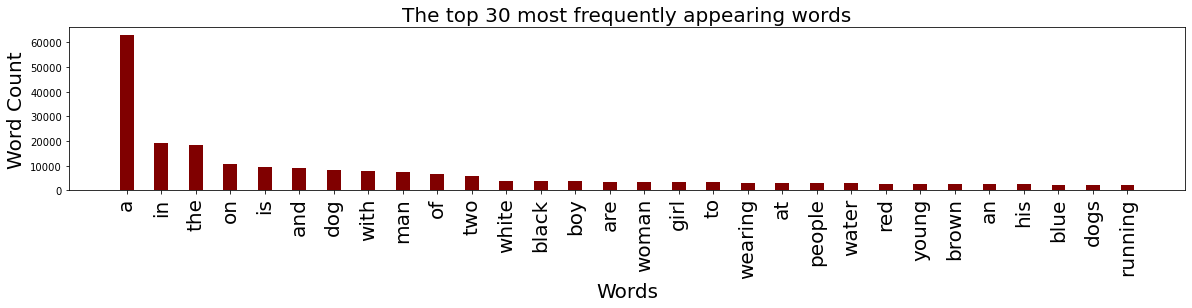

In [8]:
#Visualise the top 30 occuring words in the captions
df_word = pd.DataFrame.from_dict(val_count, orient='index')

df_word = df_word.sort_values(by=[0],ascending=False).reset_index()
df_word =df_word.rename(columns={'index':'word', 0:'count'})

def plthist(index,words,count, title="The top 30 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(words,count,color='maroon', width =0.4)
    plt.xlabel("Words",  fontsize=20) 
    plt.ylabel("Word Count",rotation=90,fontsize=20) 
   # plt.yticks(fontsize=20)
    plt.xticks(index,words,rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
    
words = list(df_word[:30].word)

count =list(df_word['count'][:30])
plthist(list(range(0,30)),words,count)

In [9]:
#Create a list which contains all the captions
df.Captions=df.Captions.apply(lambda x : f"<start> {x} <end>")
annotations=df.Captions

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path=sorted(set(all_img_vector))

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


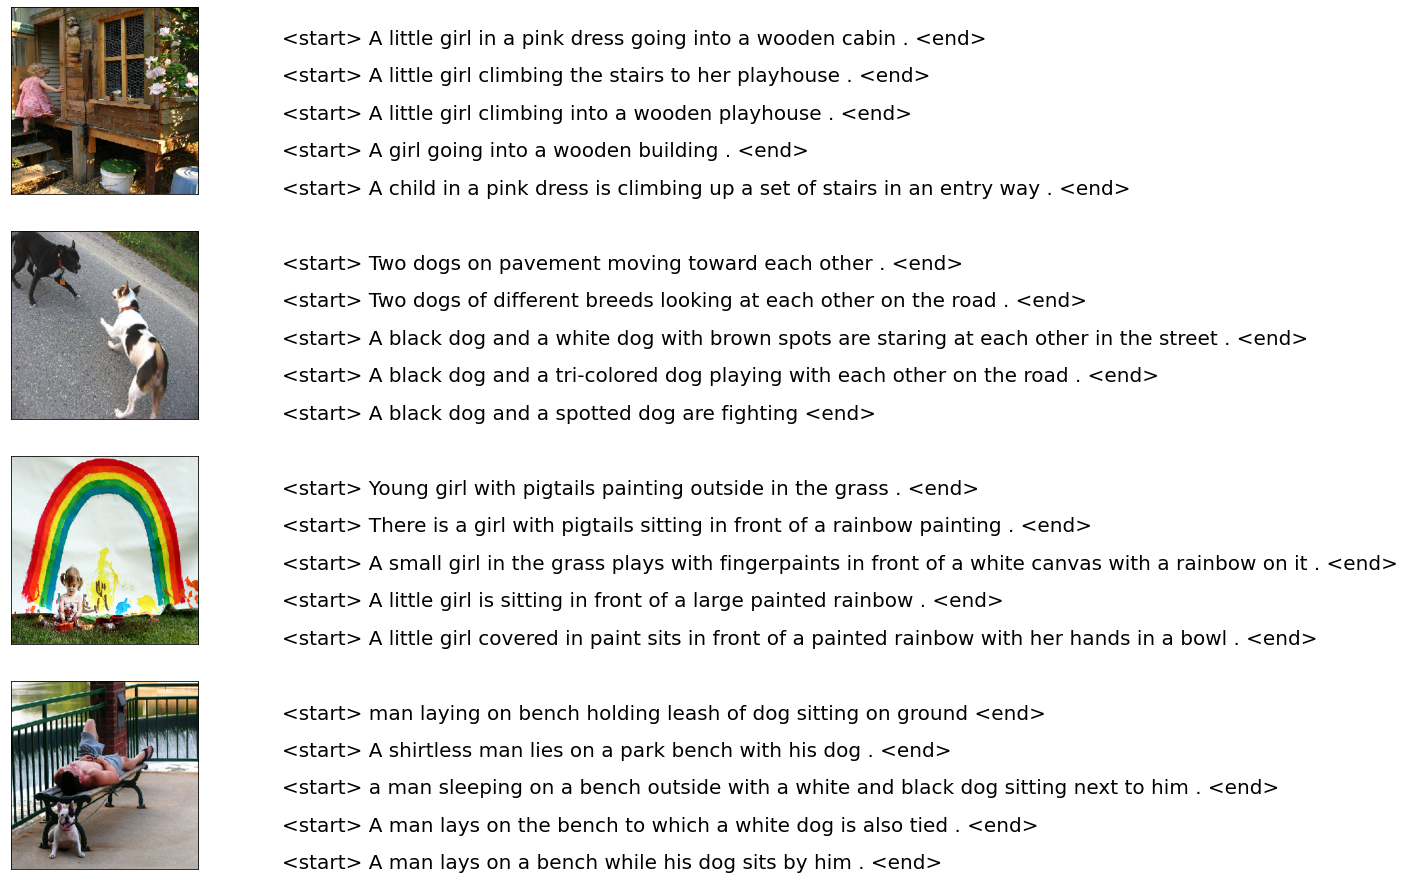

In [10]:
#Plotting image along with the captions
def plot_image_captions(Pathlist,captionsList,fig,count=2,npix=299,nimg=2):
        image_load = load_img(Path,target_size=(npix,npix,3))
        ax = fig.add_subplot(nimg,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        
        count +=1
        ax = fig.add_subplot(nimg,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
            
fig = plt.figure(figsize=(10,20))
count = 1
    
for Path in df[:20].Path.unique():
    captions = list(df["Captions"].loc[df.Path== Path].values)
    plot_image_captions(Path,captions,fig,count,299,5)
    count +=2
plt.show()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [11]:
# create the tokenizer
def tokenize_captions(top_cap,captions):
    special_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_freq_words,
                                                  oov_token="UNK",
                                                  filters=special_chars)
    tokenizer.fit_on_texts(captions)
    
    # Adding PAD to tokenizer list
    tokenizer.word_index['PAD'] = 0
    tokenizer.index_word[0] = 'PAD'   
   
    return tokenizer
#keeping only top 5000 words to save memory
top_freq_words = 5000
tokenizer = tokenize_captions(top_freq_words,annotations)

In [12]:
# Create word-to-index and index-to-word mappings.

def print_word_2_index(word):
    print("Word = {}, index = {}".format(word, tokenizer.word_index[word]))

          
print( "Word 2 index mapping")
print_word_2_index("<start>")
print_word_2_index("PAD")

def print_index_2_word(index):
    print("Index = {}, Word = {}".format(index, tokenizer.index_word[index]))

          
print( "Index 2 word mapping")

print_index_2_word(5)
print_index_2_word(4999)

Word 2 index mapping
Word = <start>, index = 3
Word = PAD, index = 0
Index 2 word mapping
Index = 5, Word = in
Index = 4999, Word = nadal


In [13]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
word_count = tokenizer.word_counts
import operator
word_count = sorted(word_count.items(), key=operator.itemgetter(1),reverse=True)
for k,v in word_count[:30]:
    print (k,v)

a 62992
<start> 40455
<end> 40455
in 18986
the 18419
on 10745
is 9345
and 8862
dog 8138
with 7765
man 7274
of 6723
two 5642
white 3959
black 3848
boy 3581
are 3504
woman 3402
girl 3328
to 3176
wearing 3062
at 2915
people 2883
water 2790
red 2691
young 2630
brown 2578
an 2432
his 2357
blue 2279


In [14]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_seqs = tokenizer.texts_to_sequences(annotations)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(cap_seqs, padding='post')

print("The shape of Caption vector is :" + str(cap_vector.shape))
print(cap_vector[:5])
max_length = max([len(cap) for cap in cap_seqs])
print("Maximium length of sequence = ", max_length)

The shape of Caption vector is :(40455, 39)
[[   3    2   44    5    2   91  173    8  120   52    2  394   13  395
     5   29    1  671    4    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   20  317   65    2  197  118    4    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   41   20  120   65    2  197 2438    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   41   20  120    6  395   21   61 2438    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   41   20    5    2   91  173  317   65    2  197 2982    4
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
    

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [15]:
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [16]:
#write your code here
BATCH_SIZE = 64
shape = (299, 299)
encode = sorted (set(all_img_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode)

image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)


In [17]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64,)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [18]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [19]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
# Get unique images
from tqdm import tqdm
encode_train = sorted(set(all_img_vector))

# Feel free to change batch_size according to your system configuration

all_imgs_npy=[]
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        file_name = p.numpy().decode("utf-8").split('/')[-1]
        all_imgs_npy.append(file_name)
        np.save(file_name, bf.numpy())

100%|██████████| 127/127 [01:00<00:00,  2.10it/s]


In [21]:
#4.1 Combine both images & captions to create the train & test dataset using tf.data.Dataset API. 
#Create the train-test spliit using 80-20 ratio & random state = 42
tf.random.set_seed(42)
img_to_cap_vector = collections.defaultdict(list)

for img,cap in zip(all_img_vector,cap_vector):
    img_to_cap_vector[img].append(cap)
# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]
#print(img_name_train_keys, img_name_val_keys)
image_train = []
captions_train = []
for imgt in img_name_train_keys:
    captions_len = len(img_to_cap_vector[imgt])
    #print(captions_len)
    image_train.extend([imgt] * captions_len)
    captions_train.extend(img_to_cap_vector[imgt])

image_test = []
captions_test = []
for imgtest in img_name_val_keys:
    captions_len = len(img_to_cap_vector[imgtest])
    image_test.extend([imgtest] * captions_len)
    captions_test.extend(img_to_cap_vector[imgtest])
print(image_test[1])
print(' ' . join([tokenizer.index_word[i] for i in captions_test[1] if i not in [0]]))

../input/flickr8k/Images/309238565_2d5d8dc8bf.jpg
<start> family purchasing standing at a vending machine <end>


In [22]:
def get_file_name(filename):
    return (images + filename)

def vector_to_sentence(caplist):
    captions_word =[]
    for captions in caplist:
        list_caption = list(captions)

        captions_word.append(' '.join(tokenizer.index_word[i] for i in list_caption))
    return captions_word

In [23]:
# Load the numpy files
def map_func(img_name, cap):
    filename = img_name.decode('utf-8').split('/')[-1] + ".npy"
    img_tensor = np.load(filename)
    return img_tensor, cap
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_dataset = tf.data.Dataset.from_tensor_slices((image_train, captions_train))
# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


test_dataset = tf.data.Dataset.from_tensor_slices((image_test, captions_test))
# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [24]:
sample_img_batch, sample_cap_batch = next(iter(test_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [25]:
embedding_dim = 256 
units = 512
vocab_size = top_freq_words+1#top 5,000 words +1
train_num_steps = len(image_train)// BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(image_test)//BATCH_SIZE#len(total test images) // BATCH_SIZE

### Encoder

In [26]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)#build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features)
        features=tf.nn.relu(features)# extract the features from the image shape: (batch, 8*8, embed_dim)
        
        return features

In [27]:
encoder=Encoder(embedding_dim)

### Attention model

In [28]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)#build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden,1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score, axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector,axis=1)# reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [29]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)#build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)#build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed =  self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        x = self.d1(output)
        x = tf.reshape(x, (-1, x.shape[2])) # shape : (batch_size * max_length, hidden_size)
        x = self.d2(x) # shape : (batch_size * max_length, vocab_size)
        
        return x,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [30]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [31]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [32]:
optimizer = tf.keras.optimizers.Adam()#define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')#define your loss object

In [33]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [34]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [35]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [36]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features=encoder(img_tensor)
        #write your code here to do the training steps
        for i in range(1, target.shape[1]):
            
            
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, total_loss

In [37]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)
            #predicted_id = tf.argmax(predictions[0])
            #dec_input = tf.expand_dims([predicted_id] * target.shape[0] , 1)
            dec_input = tf.expand_dims(target[:,i],1)
   
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [38]:
def test_loss_cal(test_dataset):
    total_loss = 0
    batch_count=0
    #write your code to get the average loss result on your test data
    for (batch,(img_tensor,target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        batch_count+=1
    #avg_test_loss=total_loss/int(target.shape[1])
    avg_test_loss=total_loss/batch_count
    return avg_test_loss

In [39]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [02:53<40:27, 173.38s/it]

For epoch: 1, the train loss is 1.257, & test loss is 1.062
Time taken for 1 epoch 173.22443890571594 sec

Test loss has been reduced from 100.000 to 1.062


 13%|█▎        | 2/15 [04:14<25:47, 119.05s/it]

For epoch: 2, the train loss is 0.981, & test loss is 0.989
Time taken for 1 epoch 80.90164995193481 sec

Test loss has been reduced from 1.062 to 0.989


 20%|██        | 3/15 [05:34<20:14, 101.24s/it]

For epoch: 3, the train loss is 0.891, & test loss is 0.978
Time taken for 1 epoch 79.92853450775146 sec

Test loss has been reduced from 0.989 to 0.978


 40%|████      | 6/15 [09:35<12:51, 85.67s/it]

For epoch: 6, the train loss is 0.739, & test loss is 0.998
Time taken for 1 epoch 80.37098264694214 sec



 47%|████▋     | 7/15 [10:55<11:11, 83.88s/it]

For epoch: 7, the train loss is 0.698, & test loss is 1.020
Time taken for 1 epoch 80.19968104362488 sec



 53%|█████▎    | 8/15 [12:15<09:38, 82.65s/it]

For epoch: 8, the train loss is 0.662, & test loss is 1.047
Time taken for 1 epoch 80.01023840904236 sec



 60%|██████    | 9/15 [13:35<08:11, 81.86s/it]

For epoch: 9, the train loss is 0.628, & test loss is 1.066
Time taken for 1 epoch 80.11824560165405 sec



 67%|██████▋   | 10/15 [14:56<06:47, 81.50s/it]

For epoch: 10, the train loss is 0.598, & test loss is 1.091
Time taken for 1 epoch 80.69354677200317 sec



 73%|███████▎  | 11/15 [16:16<05:23, 80.97s/it]

For epoch: 11, the train loss is 0.568, & test loss is 1.120
Time taken for 1 epoch 79.77610397338867 sec



 80%|████████  | 12/15 [17:37<04:03, 81.02s/it]

For epoch: 12, the train loss is 0.540, & test loss is 1.141
Time taken for 1 epoch 81.13137459754944 sec



 87%|████████▋ | 13/15 [18:57<02:41, 80.65s/it]

For epoch: 13, the train loss is 0.515, & test loss is 1.169
Time taken for 1 epoch 79.78854179382324 sec



 93%|█████████▎| 14/15 [20:18<01:20, 80.72s/it]

For epoch: 14, the train loss is 0.491, & test loss is 1.209
Time taken for 1 epoch 80.87506484985352 sec



100%|██████████| 15/15 [21:37<00:00, 86.53s/it]

For epoch: 15, the train loss is 0.468, & test loss is 1.244
Time taken for 1 epoch 79.88357782363892 sec



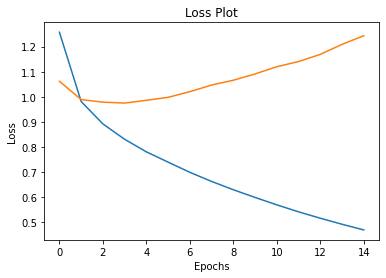

In [40]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [41]:
def evaluate(image):
    attention_plot = np.zeros((max_length, 64))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()#extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [42]:
def beam_evaluate(image, beam_index = 3):

    #write your code to evaluate the result using beam search
                 
    start = [tokenizer.word_index["<start>"]]
    # result [i][0] : word index of the ith word in result
    # result [i][1] : probability of ith word being predicted
    result = [[start, 0.0]]
    attention_plot = np.zeros((max_length,64))  
    hidden = decoder.init_state(batch_size=1)
    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    #features,dec_input = init_features(image)
    
    
    while len(result[0][0]) < max_length:
        i = 0 
        temp = []
        for s in result:
            preds, hidden, attention_weights = decoder(dec_input,features,hidden)
            attention_plot = tf.reshape(attention_weights,(-1,)).numpy()
            i +=1
            # Getting the top <beam_index>(n) predictions and creating a 
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            
            # new list  to put in the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        result = temp
        # Sorting according to the probabilities
        result = sorted(start, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        pred_id = pred_list[-1]       
        if(pred_id ==3):
            break            
                  
        dec_input = tf.expand_dims([pred_id],0)
    
    result = result[-1][0]
    intermediate_caption = [tokenizer.index_word[i] for i in start]

    final_caption = []
    
    for i in intermediate_caption:
        if i == '<end>':
            break
        final_caption.append(i)
        
    attention_plot = attention_plot[:len(result),:]
    final_caption = ' '.join(final_caption[1:])
    return final_caption,attention_plot



In [43]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [44]:
from nltk.translate.bleu_score import sentence_bleu

In [45]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BLEU score: 100.0
Real Caption: a dog jumping through a ring
Prediction Caption: a dog leaps into a tunnel


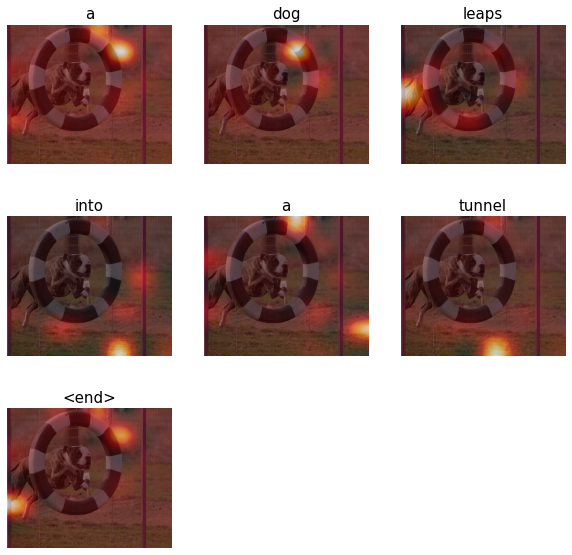

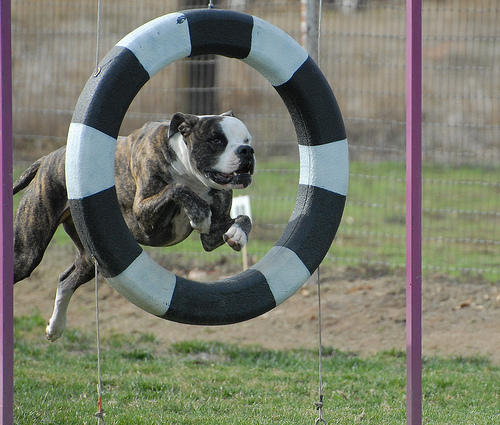

In [54]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
#test_image = '../input/flickr8k/Images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in captions_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0,0,1,0))
print(f"BLEU score: {score*100}")
print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [55]:
from pydub import AudioSegment
import IPython

# We will listen to this file:
# caption_generated.mp3
myobj = gTTS(text=pred_caption, lang='en', slow=False)
myobj.save("caption_generated.mp3")

audio_file = 'caption_generated.mp3'

IPython.display.Audio(audio_file)